In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MRI" / "MaxEnt"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)

import D1_cube_with_noise_with_roughness_normalize as dcwwn

importlib.reload(dcwwn)

<module 'D1_cube_with_noise_with_roughness_normalize' from '/Users/xunan/Projects/MRI/MaxEnt/D1_cube_with_noise_with_roughness_normalize.py'>

### Synthetic data

In [3]:
# np.random.seed(0)

qs = np.linspace(0, 3.5, 3).reshape((-1, 1), order = 'C')

thetas = np.linspace(0, 2, 1000)

voxels = 1

_, f_true = sd.synthetic_f_line_1D(thetas, voxels = voxels, normalize = True)

thetas, weights = dcwwn.Cartesian(thetas)
qs, Sqs_noisefree = sd.synthetic_Sqs_line_1D(qs, thetas, f_true, sigma=0)

SNR = 1e4

sigma = np.sqrt(np.mean(Sqs_noisefree**2) / SNR); print("Noise sigma:", sigma)

Sqs_noisy = Sqs_noisefree + np.random.normal(scale = sigma, size = (voxels, Sqs_noisefree.shape[1]))

R = np.zeros((len(qs), len(qs)))



Noise sigma: 0.005923798486734634


### Real samples of $\lambda^*$, by generating a lot of pieces of noisy signal data

In [4]:
lambdas_star, f_hat_star, obj_history = dcwwn.Newton_Armijo(  qs, thetas, weights, Sqs_noisy, 
                                        sigma = sigma, R = R, f0 = None, normalize = False,
                                        Lambdas = None,
                                        ridge = False, log_max = -2, log_min = -4, n_last = 10, 
                                        use_cg = False, pc_method = 'jacobi', cg_rtol = 1e-8, cg_maxiter = 1000, 
                                        beta=0.5, c=1e-4, tol=1e-10, epsilon = 1e-10, max_iter=500)

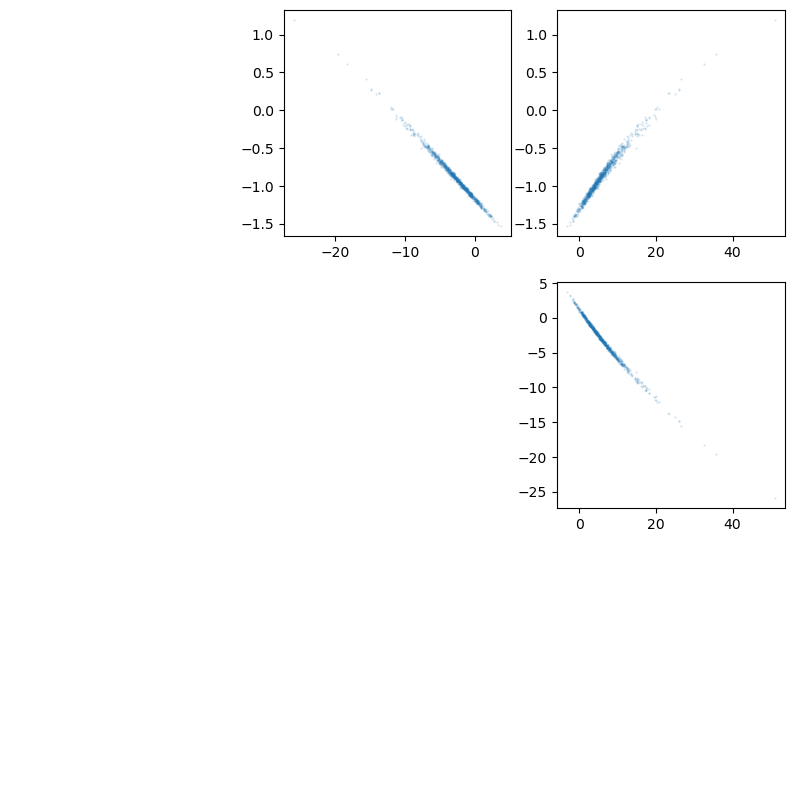

In [5]:
run = 1000

lambdas_sample = np.empty((run, len(qs)))
f_sample = np.empty((run, len(thetas)))

for i in range(run):
    Sqs_noisy_sample = Sqs_noisefree + np.random.normal(scale = sigma, size = (voxels, len(qs)))
    lambdas_hat_sample, f_hat_sample, _ = dcwwn.Newton_Armijo(  qs, thetas, weights, Sqs_noisy_sample, 
                                        sigma = sigma, R = R, f0 = None, normalize = False,
                                        Lambdas = None,
                                        ridge = False, log_max = -2, log_min = -4, n_last = 10, 
                                        use_cg = False, pc_method = 'jacobi', cg_rtol = 1e-8, cg_maxiter = 1000, 
                                        beta=0.5, c=1e-4, tol=1e-10, epsilon = 1e-10, max_iter=500)
    lambdas_sample[i, :] = lambdas_hat_sample
    f_hat_sample = f_hat_sample / (f_hat_sample @ weights)
    f_sample[i,:] = f_hat_sample

fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_sample[:, j], lambdas_sample[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity

# plt.figure(figsize=(10.5, 3))
# plt.plot(f_sample.T, '-', color = 'gray', alpha = 0.02)
# plt.plot(f_true.ravel(), '-.', color = 'orange', label = 'True')
# plt.ylim(-0.1, 3)
# # plt.legend()
# plt.title(rf'samples of $p_{{\lambda^*}}(\theta)$ with samples of $s^*$, SNR = {SNR}')
# plt.show()


## Taylor expansion

In [6]:
run = 1000

lambdas_sample_first = np.empty((run, len(qs)))
lambdas_sample_second = np.empty((run, len(qs)))
lambdas_sample_third = np.empty((run, len(qs)))

f_sample_first  = np.empty((run, len(thetas))) # store Taylor expansion samples of 1st order 
f_sample_second = np.empty((run, len(thetas))) # store Taylor expansion samples of 2nd order 
f_sample_third  = np.empty((run, len(thetas))) # store Taylor expansion samples of 3rd order 

pre_mat, fir_der, sec_der, thi_der = dcwwn.uncertainty(lambdas_star, qs, thetas, weights, Sqs_noisy_sample, sigma, R, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False)

for i in range(run):
    sample = np.random.normal(scale = sigma, size = (Sqs_noisefree.shape[0], Sqs_noisefree.shape[1])).ravel()

    delta_first  = sample @ fir_der
    delta_second = delta_first + np.einsum('i,ijk,k->j', sample, sec_der, sample) / 2  
    delta_third  = delta_second + np.einsum('ijkl,i,k,l->j', thi_der, sample, sample, sample) / 6

    x_first  = lambdas_star + delta_first
    x_second = lambdas_star + delta_second
    x_third  = lambdas_star + delta_third

    lambdas_sample_first[i, :] = x_first
    lambdas_sample_second[i, :] = x_second
    lambdas_sample_third[i, :] = x_third

    f_sample_first [i,:] = dcwwn.f_thetas_hat(x_first,  qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False).ravel()
    f_sample_second[i,:] = dcwwn.f_thetas_hat(x_second, qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False).ravel()
    f_sample_third [i,:] = dcwwn.f_thetas_hat(x_third,  qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False).ravel()

In [7]:
eigvals, eigvecs = np.linalg.eig(pre_mat)
print(eigvals)

[3.19937334e+04 1.29515073e+02 9.11370966e-02]


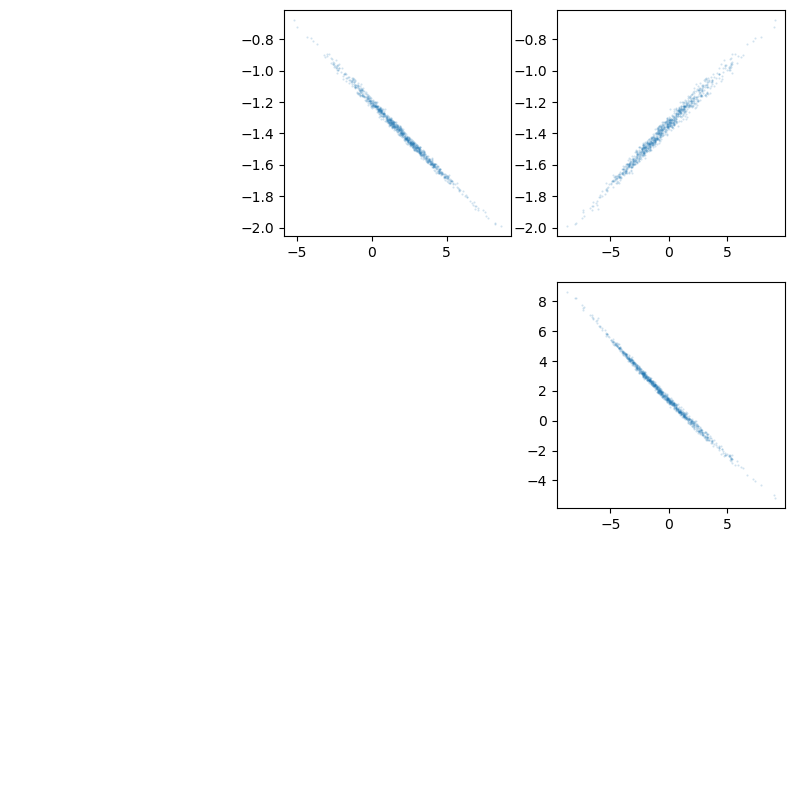

In [8]:
fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_sample_third[:, j], lambdas_sample_third[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity

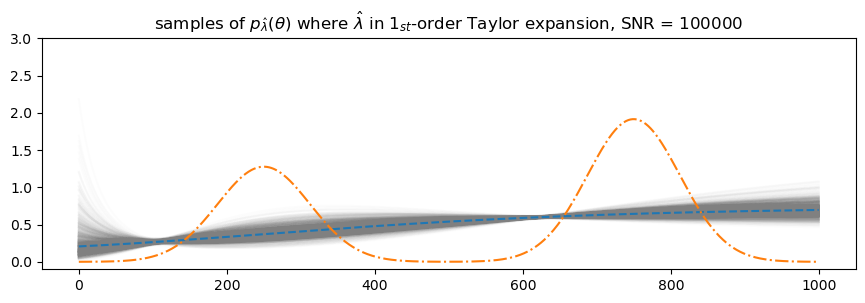

In [9]:
plt.figure(figsize=(10.5, 3))
plt.plot(f_sample_first.T, '-', color = 'gray', alpha = 0.02)
plt.plot(f_hat_star.T, '--', label = 'Mean')
plt.plot(f_true.ravel(), '-.', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(r'samples of $p_{\hat{\lambda}}(\theta)$ where $\hat{\lambda}$ in $1_{st}$-order Taylor expansion, SNR = 100000')
plt.show()

### Apply MaxEnt algorithm for the piece of noisy data and return precision matrix

In [10]:
pre_mat, _, _, _ = dcwwn.uncertainty(   lambdas_star, qs, thetas, weights, 
                                        Sqs_noisy, sigma, R, 1/np.sum(weights)*np.ones((1, len(thetas))), 
                                        normalize = False) 

### Attempt 1: use $N(\lambda^*, Q^{-1})$ as the proposal function

In [11]:
# the following function defines the proposal function
def proposal(Lambdas, pre_mat, qs):
    
    delta = bf.chol_sample(pre_mat, np.random.normal(size = len(qs)).ravel())
    Lambdas_new = Lambdas + delta 
    
    return Lambdas_new

# The following function defines the log(alpha), the log form of the accetance rate
# Since the proposal function is symmetric, we don't need to include the proposal pdf in the alpha term
def log_alpha(Lambdas_old, Lambdas_new, qs, thetas, weights, Sqs, sigma, f0):

    f_hat_new = dcwwn.f_thetas_hat(Lambdas_new, qs, thetas, weights, f0, normalize = False)   
    integral_new = np.einsum('vn,n->v', f_hat_new, weights)                                    

    f_hat_old = dcwwn.f_thetas_hat(Lambdas_old, qs, thetas, weights, f0, normalize = False)   
    integral_old = np.einsum('vn,n->v', f_hat_old, weights)                                    

    difference =  ( - integral_new + integral_old
                    - Lambdas_new @ Sqs.T + Lambdas_old @ Sqs.T
                    - 0.5* np.linalg.norm(Lambdas_new) **2*sigma**2 
                    + 0.5* np.linalg.norm(Lambdas_old) **2*sigma**2 )
    
    return difference.item()

# ---------------------------------------------------------------------------------------------------------------------

loop = 1000
rate = np.empty(loop)
lambdas_Normal = np.empty((loop, len(qs)))
f_Normal = np.empty((loop, len(thetas)))

lambdas_old = lambdas_star

for i in range(loop):

    lambdas_new = proposal(lambdas_old, pre_mat, qs)

    log_acceptance = log_alpha(lambdas_old, lambdas_new, qs, thetas, weights, Sqs_noisy, sigma, 1/np.sum(weights)*np.ones((1, len(thetas))))
    rate[i] = np.exp(log_acceptance)

    if np.log(np.random.uniform()) <= log_acceptance:
        lambdas_Normal[i, :] = lambdas_new
        lambdas_old = lambdas_new
    else:
        lambdas_Normal[i, :] = lambdas_old
        
    f_hat = dcwwn.f_thetas_hat(lambdas_old, qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False)
    f_hat = f_hat / (f_hat @ weights)
    f_Normal[i, :] = f_hat

# burn_in = 9000

# f_store = f_store[burn_in:, :]


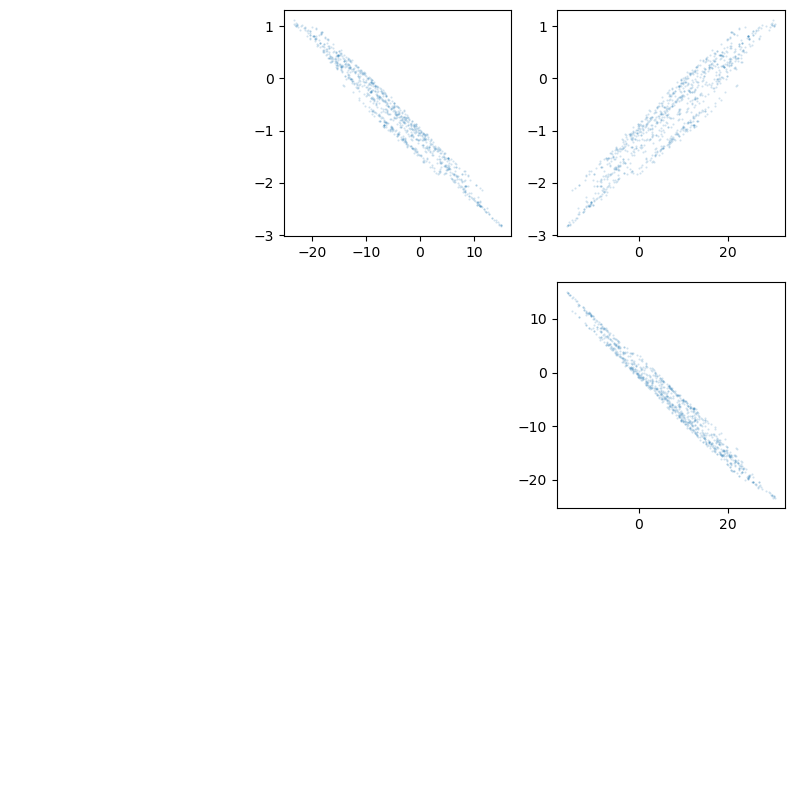

In [12]:
fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_Normal[:, j], lambdas_Normal[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity

(array([12., 14., 25., 25., 30., 50., 48., 69., 79., 91., 83., 63., 61.,
        72., 59., 70., 62., 32., 34., 21.]),
 array([-2.82619265, -2.62929575, -2.43239884, -2.23550194, -2.03860503,
        -1.84170813, -1.64481122, -1.44791432, -1.25101742, -1.05412051,
        -0.85722361, -0.6603267 , -0.4634298 , -0.26653289, -0.06963599,
         0.12726091,  0.32415782,  0.52105472,  0.71795163,  0.91484853,
         1.11174543]),
 <BarContainer object of 20 artists>)

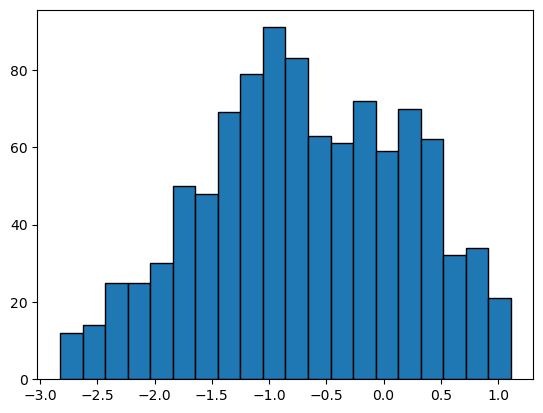

In [13]:
plt.hist(lambdas_Normal[:, 0], bins = 20, edgecolor = 'black')

In [14]:
from sklearn.linear_model import LinearRegression

X = lambdas_Normal[:, 0].reshape(-1, 1)  # scikit-learn needs 2D features
y = lambdas_Normal[:, 1]

model = LinearRegression().fit(X, y)
print("Slope:", model.coef_[0], "Intercept:", model.intercept_)

Slope: -9.429359133471548 Intercept: -11.480761997216668


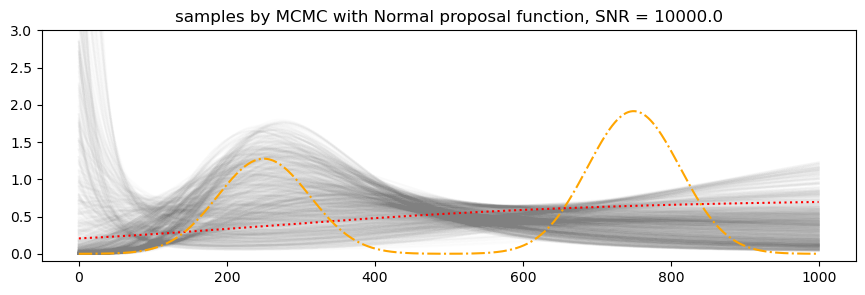

In [15]:
plt.figure(figsize=(10.5, 3))
plt.plot(f_Normal.T, '-', color = 'gray', alpha = 0.02)
plt.plot(f_hat_star.T, ':', color = 'red', label = 'hat')
plt.plot(f_true.ravel(), '-.', color = 'orange', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(rf'samples by MCMC with Normal proposal function, SNR = {SNR}')
plt.show()

### Attempt 2: use Langevin dynamic method as the proposal function. Some packages are used to do this

In [16]:
import jax
import jax.numpy as jnp
import blackjax

def Cartesian(thetas):
    weights = jnp.gradient(thetas)                                                   # in shape (N,)
    thetas = thetas.reshape((-1, 1), order = 'C')
    return thetas, weights

def kernel(qs, thetas):
    return jnp.exp( - qs @ thetas.T )                                                # in shape (M, N). M = qs.shape[0], N = thetas.shape[0]

def get_Sqs(qs, thetas, weights, f_thetas, sigma = 0):
    return kernel(qs, thetas) @ (f_thetas * weights) + jnp.random.normal(size = qs.shape[0], scale = sigma)     # in shape (M,)

def compare_KL(f_num, f_den, weights):
    return jnp.sum( weights * f_num * jnp.log( jnp.maximum(f_num / jnp.maximum(f_den, 1e-30), 1e-30) ) )

def data_check(qs, thetas, weights, Sqs, sigma, R, f0, f_hat = None):
    assert isinstance(qs, jnp.ndarray), "qs must be a numpy array"
    assert isinstance(thetas, jnp.ndarray), "thetas must be a numpy array"
    assert isinstance(weights, jnp.ndarray), "weights must be a numpy array"
    assert isinstance(Sqs, jnp.ndarray), "Sqs must be a numpy array"
    assert isinstance(sigma, (int, float)), "sigma must be a scalar"
    assert isinstance(R, jnp.ndarray), "R must be a numpy array"
    assert isinstance(f0, jnp.ndarray), "f0 must be a numpy array"
    
    if Sqs.ndim == 1:
        Sqs = Sqs[None, :]      # sometimes, for a single voxel, Sqs is a 1D array, we need to make it 2D

    if f0.ndim == 1:
        f0 = f0[None, :]        # the same reason as above, we need to make it 2D

    assert qs.ndim == 2 and qs.shape[1] == 1, "qs must be of shape (M, 1)"
    assert thetas.ndim == 2 and thetas.shape[1] == 1, "thetas must be of shape (N, 1)"
    assert weights.ndim == 1 and weights.shape[0] == thetas.shape[0], "weights must match the number of thetas"
    assert Sqs.shape[1] == qs.shape[0], "Sqs must match the number of qs"
    assert f0.shape[0] == Sqs.shape[0] and f0.shape[1] == thetas.shape[0], "f0 shape mismatch"

    if f_hat is not None:
        assert isinstance(f_hat, np.ndarray), "f_hat must be a numpy array"
        if f_hat.ndim == 1:
            f_hat = f_hat[None, :]  # the same reason as above, we need to make it 2D
        assert f_hat.shape[0] == Sqs.shape[0] and f_hat.shape[1] == thetas.shape[0], "f_hat shape mismatch"

    return qs, thetas, weights, Sqs, sigma, R, f0, f_hat

def loss_function(qs, thetas, weights, Sqs, R, f_hat, sigma, f0):
    qs, thetas, weights, Sqs, sigma, R, f0, f_hat = data_check(qs, thetas, weights, Sqs, sigma, R, f0, f_hat)

    V = Sqs.shape[0]                # number of voxels
    M = qs.shape[0]                 # number of qs
    N = thetas.shape[0]             # number of thetas

    first_term = jnp.sum( compare_KL(f_hat, f0, weights) )                       # a scalar
    
    Sigma_inv_diag = 1 / (sigma**2) * jnp.ones(V*M)                              # in shape (V*M, V*M)
    Sqs_hat = jnp.empty((V, M))                                                  # in shape (V, M)
    for i in range(V):
        Sqs_hat[i, :] = get_Sqs(qs, thetas, weights, f_hat[i, :])
    rSqs = Sqs.ravel(order='C')                                                 # in shape (V*M, )
    rSqs_hat = Sqs_hat.ravel(order='C')                                         # in shape (V*M, )
    side_vector = rSqs - rSqs_hat                                               # in shape (V*M, )
    second_term = 0.5 * side_vector @ jnp.diag(Sigma_inv_diag) @ side_vector     # a scalar

    third_term = 0.5 * rSqs_hat @ R @ rSqs_hat                                  # a scalar, the roughness regularization term
    return first_term, second_term, third_term

def f_thetas_hat(Lambdas, qs, thetas, weights, f0, normalize):

    V = Lambdas.shape[0]                # number of voxels
    N = thetas.shape[0]                 # number of thetas

    kernel_matrix = kernel(qs, thetas)  # in shape (M, N)
    f_hat = f0 * jnp.exp( jnp.clip( - Lambdas @ kernel_matrix - 1, -700, 700) ) # in shape (V, N)

    if normalize:
        f_hat /= jnp.tile((f_hat @ weights)[:, None], (1, N))  # normalize the pdf
    return f_hat

##### This defines the target posterior distribution and use the package to draw samples

In [17]:
def logprob(Lambdas, qs, thetas, weights, Sqs, sigma, f0):
    f_hat = f_thetas_hat(Lambdas, qs, thetas, weights, f0, normalize = False)                      
    integral = jnp.einsum('vn,n->v', f_hat, weights)                                                
    log_prob = - integral - Lambdas @ Sqs.T - 0.5* jnp.linalg.norm(Lambdas) **2*sigma**2
    return jnp.sum(log_prob)

# the step_size parameter is defined in the last part of the following function
mala = blackjax.mala(lambda Lambdas: logprob(Lambdas, qs, thetas, weights, 
                                             Sqs_noisy, sigma, 1/jnp.sum(weights)*jnp.ones((1, len(thetas)))), 
                                             step_size=0.5)

key = jax.random.PRNGKey(0)
init_position = jnp.array(lambdas_star.ravel())
state = mala.init(init_position)

# Sampling loop
n_samples = 1000
lambdas_Langevin = []
f_Langevin = np.empty((n_samples, len(thetas)))
keys = jax.random.split(key, n_samples)

for i in range(n_samples):
    state, _ = mala.step(keys[i], state)
    lambdas_Langevin.append(state.position)
    f_hat = f_thetas_hat(   lambdas_Langevin[i], qs, thetas, weights, 
                            1/jnp.sum(weights)*jnp.ones((1, len(thetas))), normalize = False)

    f_hat = f_hat / (f_hat @ weights)
    f_Langevin[i, :] = f_hat

lambdas_Langevin = jnp.stack(lambdas_Langevin)



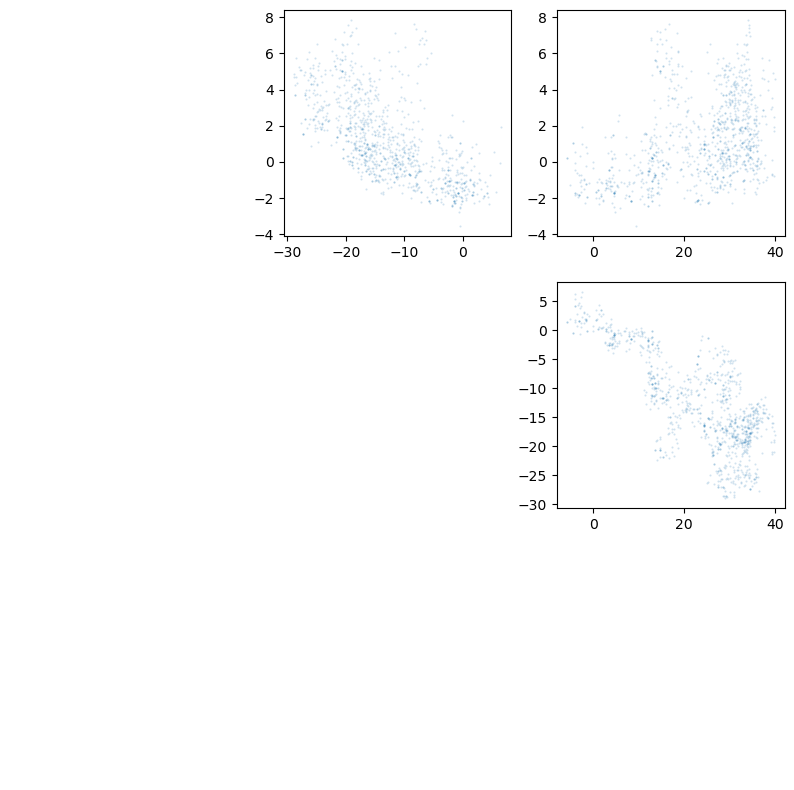

In [18]:
fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_Langevin[:, j], lambdas_Langevin[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity

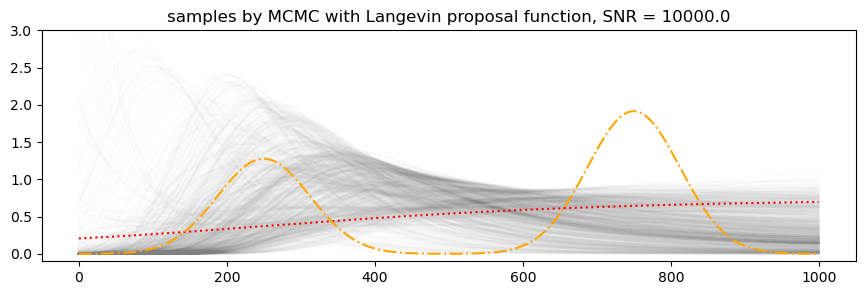

In [19]:
plt.figure(figsize=(10.5, 3))
plt.plot(f_Langevin.T, '-', color = 'gray', alpha = 0.01)
plt.plot(f_hat_star.T, ':', color = 'red', label = 'hat')
plt.plot(f_true.ravel(), '-.', color = 'orange', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(rf'samples by MCMC with Langevin proposal function, SNR = {SNR}')
plt.show()

### Attempt 3: Hamiltonian MC

In [20]:
from numpyro.infer.hmc import HMC
from numpyro.infer import MCMC

def potential_fn(params):
    Lambdas = params["Lambdas"]   
    return -logprob(
        Lambdas,
        qs, thetas, weights, Sqs_noisy, sigma,
        1/jnp.sum(weights) * jnp.ones((1, len(thetas)))
    )

key = jax.random.PRNGKey(0)
HMC_kernel = HMC(potential_fn=potential_fn, step_size=0.1, trajectory_length=1.0)
mcmc = MCMC(HMC_kernel, num_warmup=1000, num_samples=1000)
init_params = {"Lambdas": jnp.array(lambdas_star.ravel())}
mcmc.run(key, init_params=init_params)
lambdas_HMC = mcmc.get_samples()["Lambdas"] 


/Users/xunan/miniconda3/envs/general/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3962.91it/s, 23 steps of size 4.49e-02. acc. prob=0.87]


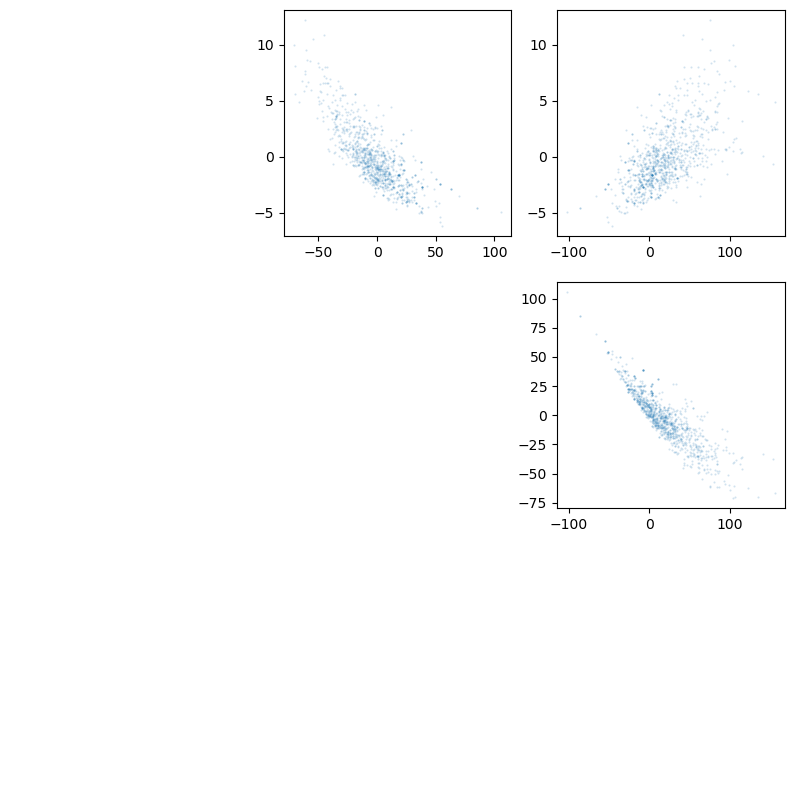

In [21]:
fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_HMC[:, j], lambdas_HMC[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity

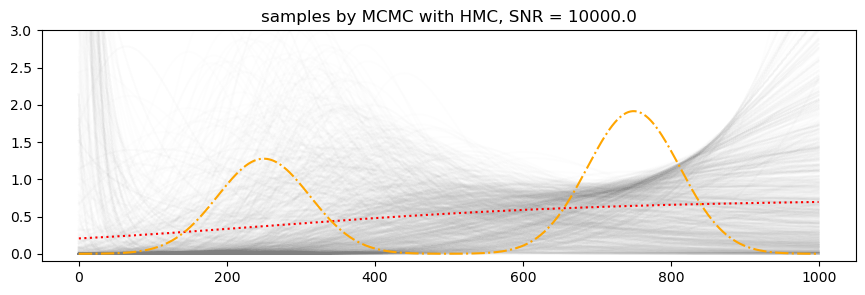

In [22]:
f_store_Hamiltonian = np.empty((1000, len(thetas)))

for i in range(1000):
    f_hat = f_thetas_hat(lambdas_HMC[i], qs, thetas, weights, 1/jnp.sum(weights)*jnp.ones((1, len(thetas))), normalize = False)
    ######################################################
    #
    # Important! I force the integral of f_hat equals to 1 in the following part
    #
    ######################################################
    f_hat = f_hat / (f_hat @ weights)
    f_store_Hamiltonian[i, :] = f_hat

plt.figure(figsize=(10.5, 3))
plt.plot(f_store_Hamiltonian.T, '-', color = 'gray', alpha = 0.01)
plt.plot(f_hat_star.T, ':', color = 'red', label = 'hat')
plt.plot(f_true.ravel(), '-.', color = 'orange', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(rf'samples by MCMC with HMC, SNR = {SNR}')
plt.show()

### Try MH MCMC

In [23]:
# the following function defines the proposal function
def proposal_MH(Lambdas, std, i):
    # only update ith position of Lambdas
    delta = np.random.normal(size = 1) * std[i]
    Lambdas_new = Lambdas.copy()
    Lambdas_new[0, i] = Lambdas[0, i] + delta.item()
    
    return Lambdas_new

def log_alpha_MH(Lambdas_old, Lambdas_new, qs, thetas, weights, Sqs, sigma, f0):

    f_hat_new = dcwwn.f_thetas_hat(Lambdas_new, qs, thetas, weights, f0, normalize = False)     # in shape (V, N)
    integral_new = np.einsum('vn,n->v', f_hat_new, weights)                                     # in shape (V, M, N)

    f_hat_old = dcwwn.f_thetas_hat(Lambdas_old, qs, thetas, weights, f0, normalize = False)     # in shape (V, N)
    integral_old = np.einsum('vn,n->v', f_hat_old, weights)                                     # in shape (V, M, N)

    difference =  ( - integral_new + integral_old
                    - Lambdas_new @ Sqs.T + Lambdas_old @ Sqs.T
                    - 0.5* np.linalg.norm(Lambdas_new) **2 * sigma**2 + 0.5* np.linalg.norm(Lambdas_old) **2*sigma**2 )
    
    return difference.item()

# ---------------------------------------------------------------------------------------------------------------------

loop = 5000
std = np.ones(len(qs))
rate = np.empty((len(qs),loop))

lambdas_MH = np.empty((loop, len(qs)))
f_MH = np.empty((loop, len(thetas)))

lambdas_old = lambdas_star

for i in range(loop):

    for j in range(len(qs)):
        if i >= 100 and i % 100 == 0:
            # print(f'{j}th acceptance rate = {rate[j, i-100:i].mean()}')
            if rate[j, i-100:i].mean() < 0.2:
                std[j] = std[j]*0.8

            if rate[j, i-100:i].mean() > 0.4:
                std[j] = std[j]/0.8

        lambdas_new = proposal_MH(lambdas_old, std, j)

        log_acceptance = log_alpha_MH(lambdas_old, lambdas_new, 
                                   qs, thetas, weights, Sqs_noisy, sigma, 1/np.sum(weights)*np.ones((1, len(thetas))))
        if log_acceptance > 0:
            log_acceptance = 0
        rate[j, i] = np.exp(log_acceptance)

        if np.log(np.random.uniform()) <= log_acceptance:
            lambdas_old = lambdas_new

    lambdas_MH[i, :] = lambdas_old
        
    f_hat = dcwwn.f_thetas_hat(lambdas_old, 
                               qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False)
    f_hat = f_hat / (f_hat @ weights)
    f_MH[i, :] = f_hat

burn_in = 4000

lambdas_MH = lambdas_MH[burn_in:, :]
f_MH = f_MH[burn_in:, :]


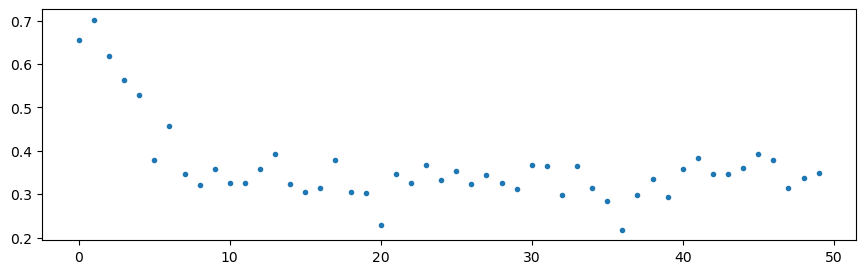

In [24]:
plt.figure(figsize=(10.5, 3))
plt.plot(rate[0].reshape(-1, 100).mean(axis = 1), '.')

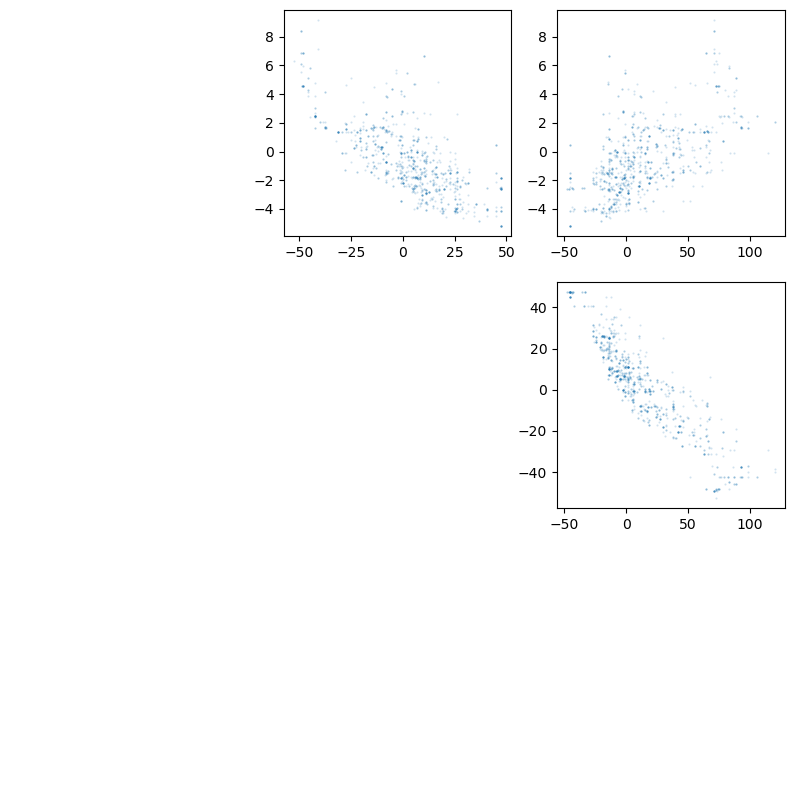

In [25]:
fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_MH[:, j], lambdas_MH[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity

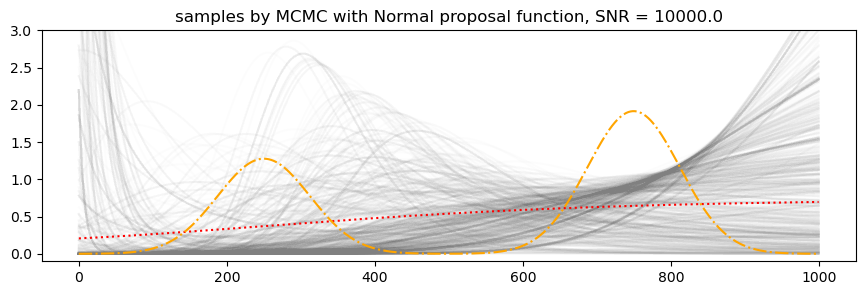

In [26]:
plt.figure(figsize=(10.5, 3))
plt.plot(f_MH.T, '-', color = 'gray', alpha = 0.02)
plt.plot(f_hat_star.T, ':', color = 'red', label = 'hat')
plt.plot(f_true.ravel(), '-.', color = 'orange', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(rf'samples by MCMC with Normal proposal function, SNR = {SNR}')
plt.show()

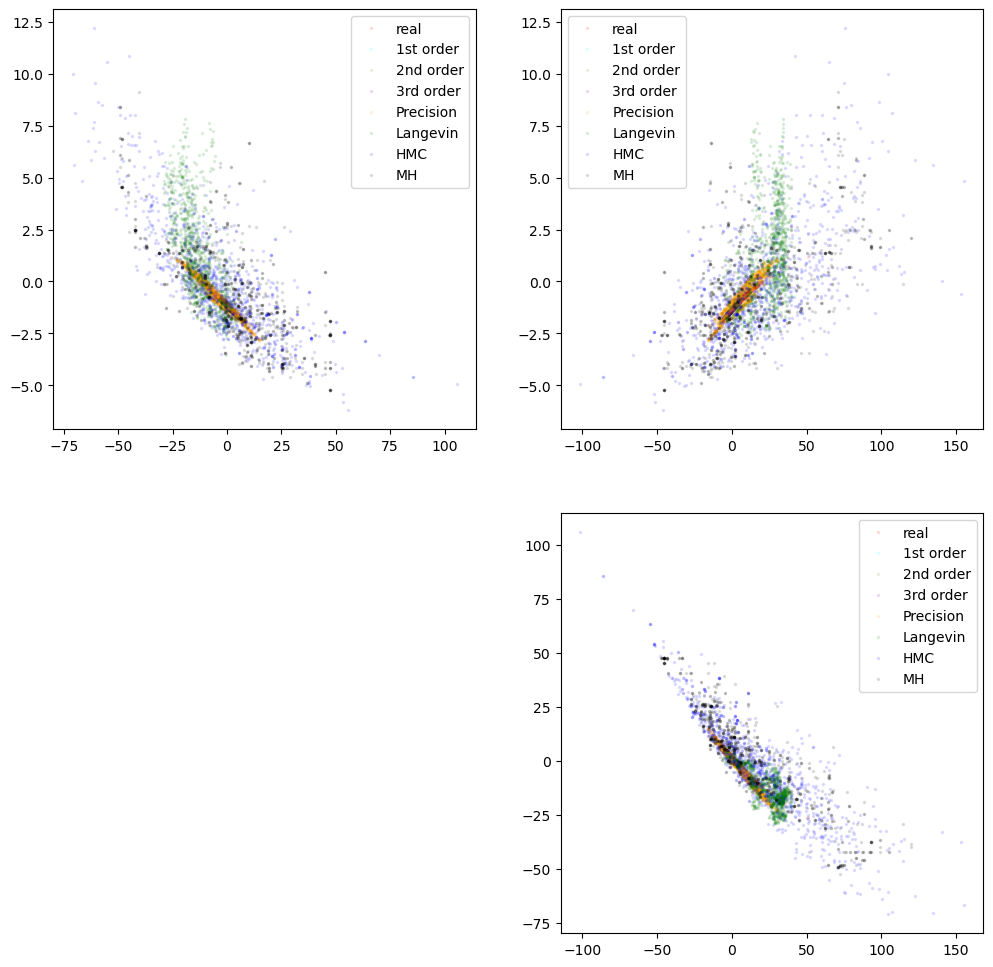

In [32]:
fig, axes = plt.subplots(len(qs)-1, len(qs)-1, figsize=(12, 12))  # n×n grid

for i in range(len(qs)-1):
    for j in range(len(qs)-1):
        ax = axes[i, j]
        if j >= i:
            ax.plot(lambdas_sample[:, j+1], lambdas_sample[:, i], '.', markersize = 3, alpha=0.1,
                    color = 'red', label = 'real')
            ax.plot(lambdas_sample_first[:, j+1], lambdas_sample_first[:, i], '.', markersize = 3, alpha=0.1,
                    color = 'cyan', label = '1st order')
            ax.plot(lambdas_sample_second[:, j+1], lambdas_sample_second[:, i], '.', markersize = 3, alpha=0.1,
                    color = 'olive', label = '2nd order')
            ax.plot(lambdas_sample_third[:, j+1], lambdas_sample_third[:, i], '.', markersize = 3, alpha=0.1,
                    color = 'purple', label = '3rd order')
            ax.plot(lambdas_Normal[:, j+1], lambdas_Normal[:, i], '.', markersize = 3, alpha=0.1,
                    color = 'orange', label = 'Precision')
            ax.plot(lambdas_Langevin[:, j+1], lambdas_Langevin[:, i], '.', markersize = 3, alpha=0.1,
                    color = 'green', label = 'Langevin')
            ax.plot(lambdas_HMC[:, j+1], lambdas_HMC[:, i], '.', markersize = 3, alpha=0.1,
                    color = 'blue', label = 'HMC')
            ax.plot(lambdas_MH[:, j+1], lambdas_MH[:, i], '.', markersize = 3, alpha=0.1, 
                    color = 'black', label = 'MH')
            ax.legend()
        else:
            ax.axis('off')  # blank lower triangle for clarity